pclass: A proxy for socio-economic status (SES)

1st = Upper

2nd = Middle

3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)


parch: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

# EDA

### main info

In [45]:
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (891, 11)
test shape: (418, 10)


In [3]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [7]:
train.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

## Категориальные признаки

In [8]:
train.dtypes[train.dtypes == object].index

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

### Name

Список самых частых слов:

In [13]:
dictionary = {}
for words in train.Name:
    for word in words.replace(',', ' ').split():
        dictionary[word] = dictionary.pop(word, 0) + 1
sorted(list(dictionary.items()), key = lambda x: x[1], reverse=True)[:10]

[('Mr.', 517),
 ('Miss.', 182),
 ('Mrs.', 125),
 ('William', 62),
 ('John', 44),
 ('Master.', 40),
 ('Henry', 34),
 ('James', 24),
 ('Charles', 23),
 ('George', 22)]

In [16]:
pref_list = ['Mr.', 'Miss.', 'Mrs.', 'Master.']

def return_pref(string):
    for pref in pref_list:
        if pref in string:
            return pref
    else:
        return 'Other'
train['Pref_name'] = train['Name'].apply(return_pref)

In [24]:
train.groupby('Pref_name').mean().sort_values('Survived', axis=0)

,Survived,Pclass,Age,SibSp,Parch,Fare
Pref_name,,,,,,
Mr.,0.156673,2.410058,32.368090,0.288201,0.152805,24.441560
Other,0.444444,1.333333,42.384615,0.296296,0.074074,39.111422
Master.,0.575000,2.625000,4.574167,2.300000,1.375000,34.703125
Miss.,0.697802,2.307692,21.773973,0.714286,0.549451,43.797873
Mrs.,0.792000,2.000000,35.898148,0.696000,0.832000,45.138533


In [18]:
train.groupby('Pref_name').count()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Pref_name,,,,,,,,,,,
Master.,40,40,40,40,36,40,40,40,40,7,40
Miss.,182,182,182,182,146,182,182,182,182,47,181
Mr.,517,517,517,517,398,517,517,517,517,93,517
Mrs.,125,125,125,125,108,125,125,125,125,44,124
Other,27,27,27,27,26,27,27,27,27,13,27


### Sex

In [9]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


Большинство виживших являются женщины, признак является важным.

### Cabin

In [20]:
train[['Cabin', 'Survived']].groupby('Cabin').mean()

,Survived
Cabin,
A10,0.0
A14,0.0
A16,1.0
A19,0.0
A20,1.0
...,...
F33,1.0
F38,0.0
F4,1.0


Попробуем взять только номер кабины:

In [48]:
train['Cabin_letter'] = train.Cabin.apply(lambda x: x[0] if type(x) == str else "Unknown")

train.groupby('Cabin_letter').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Cabin_letter,,,,,,
A,0.466667,1.000000,44.833333,0.133333,0.133333,39.623887
B,0.744681,1.000000,34.955556,0.361702,0.574468,113.505764
C,0.593220,1.000000,36.086667,0.644068,0.474576,100.151341
D,0.757576,1.121212,39.032258,0.424242,0.303030,57.244576
E,0.750000,1.312500,38.116667,0.312500,0.312500,46.026694
F,0.615385,2.384615,19.954545,0.538462,0.538462,18.696792
G,0.500000,3.000000,14.750000,0.500000,1.250000,13.581250
T,0.000000,1.000000,45.000000,0.000000,0.000000,35.500000
Unknown,0.299854,2.639010,27.555293,0.547307,0.365357,19.157325


In [24]:
train[['Cabin_letter', 'Survived']].groupby('Cabin_letter').count()

,Survived
Cabin_letter,
A,15
B,47
C,59
D,33
E,32
F,13
G,4
T,1
Unknown,687


У людей с кабиной вероятность выжить выжить больше, чем у людей без. Возможно, можно учесть только наличие кабины

### Embarked

In [50]:
train.groupby('Embarked').count()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Cabin_letter
Embarked,,,,,,,,,,,
C,168,168,168,168,130,168,168,168,168,69,168
Q,77,77,77,77,28,77,77,77,77,4,77
S,644,644,644,644,554,644,644,644,644,129,644


In [51]:
train.groupby('Embarked').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,
C,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
Q,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
S,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


Процент выживших между C и S отличается где-то в 2.5 раза. Признак стоит рассматривать

## Числовые признаки

In [35]:
num_cols = list(train.dtypes[train.dtypes != object].index)
num_cols

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

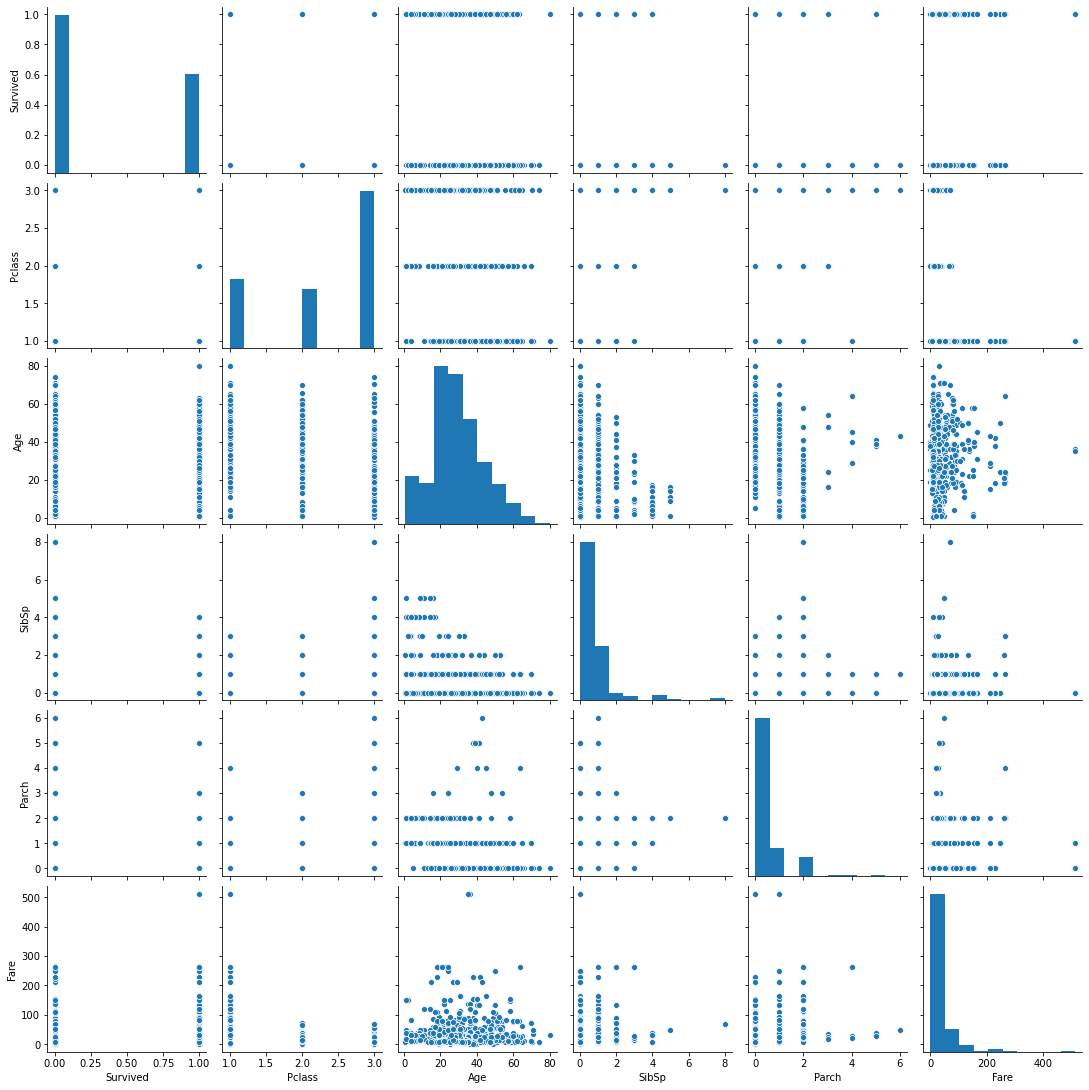

In [34]:
sns.pairplot(train[num_cols])

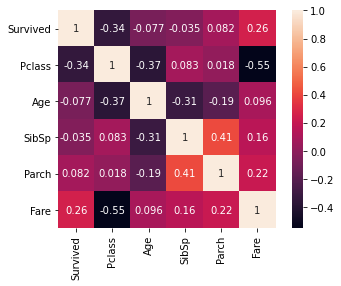

In [39]:
sns.heatmap(train[num_cols].corr(), square=True,annot=True);

Посмотрим подробнее отдельно для женщин и мужчин:

Text(0.5, 1.0, 'Male')

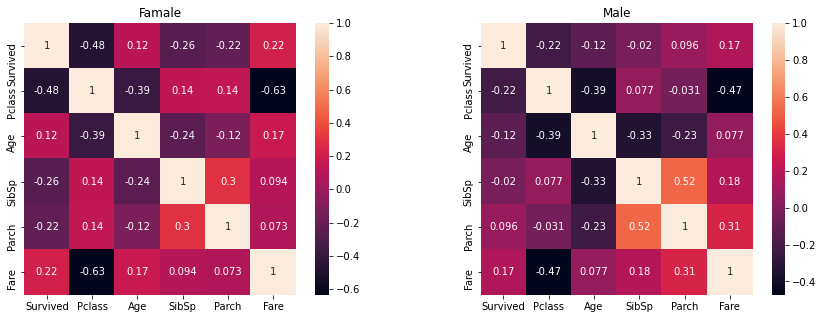

In [51]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.heatmap(train[num_cols][train.Sex =='female'].corr(), square=True,annot=True, ax =axs[0]);
sns.heatmap(train[num_cols][train.Sex =='male'].corr(), square=True,annot=True, ax =axs[1]);

axs[0].set_title('Famale')
axs[1].set_title('Male')

У женщин  в первую очередь влияет класс обслуживания, потом идет наличие родственников и билет.
У мужчин идет класс, билет, возраст и класс влияют примерно одинакого.

Если придется восстанавливать возраст, то множно обратить внимание на класс, и наличие родственников

# Преобразование признаков

In [62]:
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')



In [63]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [64]:
datasets = [train, test]

In [65]:
for data in datasets:
    #Name
    pref_list = ['Mr.', 'Miss.', 'Mrs.', 'Master.']

    def return_pref(string):
        for pref in pref_list:
            if pref in string:
                return pref
        else:
            return 'Other'
        
    data['Name'] = data['Name'].apply(return_pref)
    data.Name = data.Name.map({'Mr.':0, 'Other':1, 'Master.':2, 'Miss.':3, 'Mrs.':4})
    
    #Sex
    data.Sex = data.Sex.map({'male': 0, 'female': 1})
    
    #Family size
    data['Family_size'] = data.SibSp + data.Parch + 1
    data['Is_alone'] = data['Family_size'].apply(lambda x: 1 if x==1 else 0)
    
    #Cabin
    data.Cabin = data.Cabin.apply(lambda x: 1 if type(x) == str else 0)
    
    #Embarked
    mode = datasets[0].Embarked.mode()
    data.Embarked = data.Embarked.fillna('S')
    data.Embarked = data.Embarked.map({'C': 0, 'Q': 1, 'S': 2})
    
    #Fare
    median_fare =  datasets[0].Fare.median()
    for data in datasets:
        data.Fare = data.Fare.fillna(median_fare)
    
#Age
merged_df = pd.concat(datasets)   
for i in range(5):
    median_age = merged_df.loc[merged_df['Name']==i,'Age'].median()
    for data in datasets:
        data.loc[data.Name==i,'Age'] = data.loc[data.Name==i,'Age'].fillna(median_age)
   

In [86]:
drop_cols = ['SibSp', 'Parch', 'Ticket', 'Family_size', 'Cabin']

train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

KeyError: "['SibSp' 'Parch' 'Ticket' 'Family_size' 'Cabin'] not found in axis"

In [67]:
train

,Survived,Pclass,Sex,Age,Fare,Is_alone
PassengerId,,,,,,
1,0,3,0,22.0,7.2500,0
2,1,1,1,38.0,71.2833,0
3,1,3,1,26.0,7.9250,1
4,1,1,1,35.0,53.1000,0
5,0,3,0,35.0,8.0500,1
...,...,...,...,...,...,...
887,0,2,0,27.0,13.0000,1
888,1,1,1,19.0,30.0000,1
889,0,3,1,22.0,23.4500,0


# Обучение модели

### XGBoost

In [68]:
X = train.drop('Survived', axis=1).to_numpy()
y = train.Survived

In [69]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

In [70]:
gbm = xgb.XGBClassifier(
 learning_rate = 0.001,
 n_estimators= 3000,
 max_depth= 3,
 min_child_weight= 2,
 #gamma=1,
 gamma=1,                        
 subsample=0.5,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)


gbm.fit(X_train, y_train)
xgb_predictions = gbm.predict(X_test)
print(accuracy_score(y_test, xgb_predictions))

0.8156424581005587


Перебор по сетке

In [71]:
grid = {
    'learning_rate': [0.01, 0.0005, 0.005],
    'n_estimators': [400, 500, 600],
    'max_depth': [2, 3, 5],
    'subsample':[0.5]
}

In [72]:
xgb_grid = GridSearchCV(xgb.XGBClassifier(), param_grid=grid, n_jobs=-1)

In [73]:
xgb_grid.fit(X, y)

GridSearchCV(estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.0005, 0.005],
                         'max_depth': [2, 3, 5],
                         'n_estimators': [400, 500, 600], 'subsample': [0.5]})

In [74]:
xgb_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.5}

In [75]:
xgb_grid.best_score_

0.8462808361057057

In [81]:
best_xgbm = xgb_grid.best_estimator_

### Random Forest

In [8]:
X = train.drop('Survived', axis=1).to_numpy()
y = train.Survived

In [9]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

In [66]:
rand_forest = RF(max_depth=50, n_estimators=500)

rand_forest.fit(X_train, y_train)
print(rand_forest.score(X_test, y_test))

0.8212290502793296


In [70]:
rand_forest.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [76]:
param_grid = {'max_depth': [None],
              'n_estimators': [1000],
              'min_samples_leaf': [1],
              'criterion':['gini', 'entropy'],
              'oob_score': [False],
              'class_weight':['balanced', None] 
             }

In [77]:
grid_rf = GridSearchCV(RF(), param_grid, scoring = 'accuracy', n_jobs=-1)

In [78]:
%%time 
grid_rf.fit(X, y)

Wall time: 8.72 s


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'], 'max_depth': [None],
                         'min_samples_leaf': [1], 'n_estimators': [1000],
                         'oob_score': [False]},
             scoring='accuracy')

In [79]:
grid_rf.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'n_estimators': 1000,
 'oob_score': False}

In [80]:
grid_rf.best_score_

0.8137279517921036

In [104]:
best_rf = grid_rf.best_estimator_

# Создание отчета

In [82]:
def create_answer(results, name):
    idx = list(pd.read_csv('test.csv').PassengerId)
    my_results = pd.DataFrame({'PassengerId': idx, 'Survived':results})
    my_results.to_csv(name, index=False)

In [83]:
X_test = test.to_numpy()

In [84]:
results = best_xgbm.fit(X, y).predict(X_test)

In [85]:
create_answer(results, 'my_answer_9.csv')